In [3]:
suppressWarnings(suppressMessages(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE)))
suppressWarnings(library(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ggplot2, quietly = TRUE, warn.conflicts = FALSE))
library(pryr, quietly = TRUE, warn.conflicts = FALSE))

set.seed(27182)

Warning message:
"package 'pryr' was built under R version 4.0.5"

Attaching package: 'pryr'


The following objects are masked from 'package:purrr':

    compose, partial




# In this module you will learn:

1. Basic R data manipulation
2. How to implement and use cross-validation
3. Select the number of terms to include in a polynomial regression

## Basic R data manipulation

The basic statistical types in R are vectors, matrices, and data.frames. `c()` (concatente) can produce vectors. Data.frames have `row.names` that can either be an integer or string vector.

In [3]:
v = c(1,2,3)
print(v)
m = matrix(c(1,3,5,7), ncol=2)
print(m)
d = data.frame(a=1:3, b=3:5, c=5:7)
print(d)

[1] 1 2 3
     [,1] [,2]
[1,]    1    5
[2,]    3    7
  a b c
1 1 3 5
2 2 4 6
3 3 5 7


The normal operators work fine on these data types

In [4]:
print(v+v)
print(v*v) #element-wise
print(m %*% m) #matrix multiply

[1] 2 4 6
[1] 1 4 9
     [,1] [,2]
[1,]   16   40
[2,]   24   64


Indexing can be with integers or boolean masks

In [5]:
print(v[c(TRUE,TRUE,FALSE, FALSE)])
print(v[c(1,2)])
print(m[c(1), c(FALSE, TRUE)])

[1] 1 2
[1] 1 2
[1] 5


Data.frames columns can be accessed either by name or index position. Rows use the tuple method

In [6]:
print(d["c"])
print(d$b) #drops to a vector
print(d[c(1,2)])
print(d[c(1,2), c("a"), drop=FALSE]) #drop=FALSE keeps it from dropping rank down to a vector

  c
1 5
2 6
3 7
[1] 3 4 5
  a b
1 1 3
2 2 4
3 3 5
  a
1 1
2 2


While most languages allow `vector+scalar`, R generalizes this concept by "recycling" the shorter one so that it works non-scalars. This can sometimes hide errors, so be careful.

In [7]:
print(1:4 + 1:2) #actually 1:4 + c(1,2,1,2)
print(1:4 + 1:3) #actually 1:4 + c(1,2,3,1), but throws an warning

[1] 2 4 4 6


Warning message in 1:4 + 1:3:
"longer object length is not a multiple of shorter object length"


[1] 2 4 6 5


R is 1-based indexing so [1] identifies the first element. And sequences `start`:`end` are inclusive.

In [8]:
v = c(1,2,3,4)
print(v[1])
print(v[2:3])

[1] 1
[1] 2 3


Usually variables are "passed by value" in R (with some efficiencies to save on space). If you want to modify an object, you typically return the modified object.

In [9]:
mod_vars <- function(v) {
    v[1] = 10
}
v = c(1,2,3)
print(v)
mod_vars(v)
print(v)

[1] 1 2 3
[1] 1 2 3


## Figuring things out
Ways to figure things out:
1. `?...`
2. Cran PDF help
3. Try things out!

In [43]:
?lm

# CV
Instead of using real data we are going to generate our own. Why might we want to do this? We want to see if cross-validation works. If we use real data we don't know what the true model looks like. If we create the model ourselves we can determine if the process actually works!

## Generating Data
Lets generate data from a fourth order polynomial: $y=\beta_0+\beta_1x+\beta_2x^2+\beta_3x^3+\beta_4x^4+\varepsilon$

The following code snippet shows how we can do this.


In [8]:
#Mean outcome function
degree4_ybar <- function(x1) {
    beta_true = matrix(c(.2,-.01,.3,-.005)) # coefficient vector
    alpha_true = 1
    #featurize
    x2 = x1^2 # squared    
    x3 = x1^3 # cubed     
    x4 = x1^4 # 4th power 
    X = cbind(x1,x2,x3,x4) # X is the concatenation of 4 column vectors
    
    ybar = alpha_true + X%*%beta_true
    return(ybar)
}

#Generate random data
degree4_dgp <- function(N) {
    x1 = runif(N,-2,2) # generate N uniform rvs between -2,2
    ybar = degree4_ybar(x1)
    y = ybar + rnorm(N)*1.5
    # y is generated from a 4th order polynomial with N(0,2.25) errors   
    data = data.frame(cbind(y,x1))               
    # creates a data frame from the "observed" covariates y and x 
    colnames(data) = c('y', 'x')
    return(data)
}
N = 1500
data = degree4_dgp(N)
head(data)

,y,x
,<dbl>,<dbl>
1,-3.8031504,-1.9561835
2,2.5147054,-0.3642259
3,0.3381272,-0.5018784
4,-0.2740717,-0.5853449
5,4.1420894,1.6863814
6,2.6749169,-1.1486379


**Visualization**

In practice we don't know the order of the polynomial. We only observe observations from $y$ and $x$. A great way to begin our examination of the truth would be to visualize the relationship through a scatter plot!



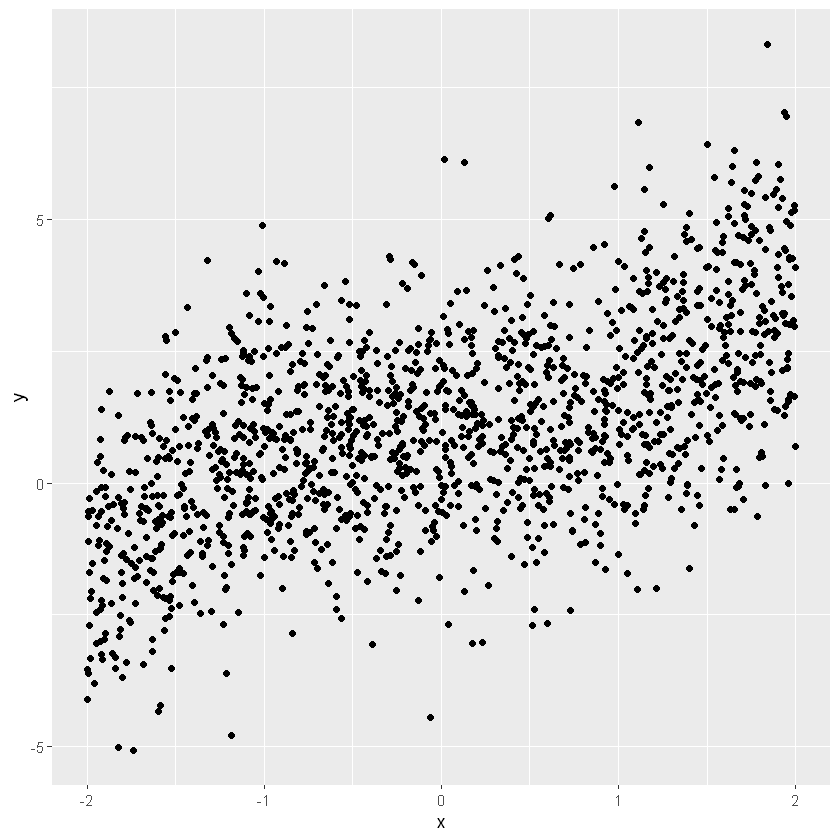

In [10]:
data %>% ggplot(aes(x=x, y=y)) + geom_point()                

**What do we see?**

The scatter plot suggests the relationship is nonlinear, but we need still don't know how many terms to include in a polynomial regression.

## In-sample vs out-of-sample errors

In [12]:
max_p = 8

fit_poly <- function(d, p) {
    deg=p
    #Need the substitute(...) otherwise in predict it look again for 'p' (not fixed p used when fitting). Need 'deg=p' so it's found in this scope. If not in funciton, use pryr::subs
    lm(pryr::subs(y~poly(x, degree=deg, raw=TRUE)), d)
}
fit_polys <- function(d, max_p) {
    fit_models = list()
    for(p in 1:max_p) {
        fit_models[[p]] = fit_poly(d,p)
    }
    return(fit_models)
}
fit_models = fit_polys(data, max_p)

is_mses = c()
for(p in 1:max_p) {
    y_hat = predict(fit_models[[p]])
    is_mses[p] = mean((y_hat - data[["y"]])^2)
}
print(is_mses)

[1] 2.491914 2.491896 2.352930 2.350218 2.348243 2.348001 2.343787 2.342420


In [14]:
pop_size = 10000
true_oos_mse <- function(fit_model, dgp, N_new=pop_size) {
    #For a known DGP we could analytically determine the true oos MSE, but this is simple and more general
    data_val = dgp(N_new)
    y_hat = predict(fit_model, newdata=data_val)
    mean((y_hat-data_val[["y"]])^2)
}

oos_mses = c()
for(p in 1:max_p) {
    oos_mses[p] = true_oos_mse(fit_models[[p]], degree4_dgp)
}
print(oos_mses)

[1] 2.376976 2.374946 2.287985 2.235902 2.274968 2.324239 2.229549 2.236690


In [24]:
bias_var_decomp <- function(data, models, ybar_fn) {
    S = length(models)
    N = nrow(data)
    
    yhat = matrix(,nrow=N, ncol=S)
    for(s in 1:S) {
        yhat[,s] = predict(models[[s]], data)
    }
    
    yhat_bar = rowMeans(yhat)
    ybar = ybar_fn(data[["x"]])
    m_bias2 = (yhat_bar - ybar)^2
    m_var = rowMeans((yhat - yhat_bar)^2) #Mat - vec does it for each column
    m_mse = mean((yhat - data[["y"]])^2)
    return(c(mean(m_bias2), mean(m_var), m_mse))
}

In [39]:
n_sim=1000
d_val = degree4_dgp(pop_size)
is_mse_sim = matrix(,nrow = n_sim, ncol=max_p)
m_bias = c()
m_var = c()
m_oos_mse = c()
data_sim = lapply(1:n_sim, function(s) degree4_dgp(N))
for(p in 1:max_p) {
    fits = list()
    for(s in 1:n_sim) {
        d = data_sim[[s]]
        fits[[s]] = fit_poly(d, p)
        is_mse_sim[s,p] = mean((predict(fits[[s]]) - d[["y"]])^2)
    }
    bv_ret = bias_var_decomp(d_val, fits, degree4_ybar)
    m_bias[p] = bv_ret[1]
    m_var[p] = bv_ret[2]
    m_oos_mse[p] = bv_ret[3]
}
is_mse_sim_mean = colMeans(is_mse_sim) 

In [11]:
metrics = data.frame(p=1:max_p, bias = m_bias, var=m_var, is=is_mse_sim_mean, oos = m_oos_mse)
print(metrics)
metrics %>% select(p, bias, var) %>% pivot_longer(!p, names_to="type", values_to="val") %>% ggplot(aes(x=p, y=val, color=type)) + geom_line()
metrics %>% select(p, is, oos) %>% pivot_longer(!p, names_to="type", values_to="val") %>% ggplot(aes(x=p, y=val, color=type)) + geom_line()

ERROR: Error in data.frame(p = 1:max_p, bias = m_bias, var = m_var, is = is_mse_sim_mean, : object 'max_p' not found


## Estimating OOS and CV

### Sample Splitting

Cross-validation can help us choose the right model! Since we are doing data driven model selection we first want to split our data so that we have a validation sample. Let's go ahead and take $10\%$ of the sample for validation.

Note: If your data has particular structure (panel, clustering, etc) you want to be careful about how you split/shuffle the data. In this case we know the structure and it will be ok to just slice off a random subsample.


The following snippet is an example of a function. We will use a few of these throughout the course just to get an idea for what they look like. In this function we specify the data and how much of that data needs to be set asside for validation, the default is $10\%$.

In [11]:
#Splitting the data

data_split = function(data,split=.1){
    N = dim(data)[1]
    
    # Randomly split by shuffling data
    random = sample(1:N,N,replace=F)          
    data = data[random,]
    
    c = round(N*split)
    test = data[1:c,]           
    train = data[(c+1):N,]
    
    return(list(train,test))
}


tmp = data_split(data) 
train_test = tmp[[1]]
validation = tmp[[2]]

**Number of terms**


Before we can begin to utilize cross-validaiton we need to choose $P$, the number of models we are considering. The larger $P$ is, the longer our computation will take. However, we want to make sure the true $P$ is among the choices. This choice is going to be somewhat arbitrary, but higher order polynomial terms tend to have very small coefficients so we should be able to get away with something around $P=8$. 

**Number of folds?**

Remember we also have to choose the number of folds $k$. In general we want to choose $k$ small enough that the correlation between samples doesn't get too large, but $k$ large enough that we split enough times. The standard choices are also a bit arbitrary but perform well in practice $k=5$ or $k=10$.



### Cross-Validation

Let's go ahead and look at $p={1,2,\dots,8}$ and $k=5$. The first model will be the simple linear case: $y=\beta_0+\beta_1 x+\varepsilon$.

There are many packages that implement cross-validation in R. We will use a few of these in later modules, but just so you can see what is happening under the hood this is a direct implementation.

In [19]:
CV_linear = function(train_test, n_folds, p=1){
    N = dim(train_test)[1] # Number of observations
    
    MSE = array(,c(n_folds)) #MSE evaluated on the test data
    yhat = array(,c(N, n_folds))

    for (i in 1:n_folds){                                  
        # This block just assigns train/test to each fold

        test_mask = mod(1:n_folds - 1, n_folds) + 1 ==i
        
        # Once we have our train/test folds we want to estimate 
        # the model on the training set and predict on the test
        fit = fit_poly(train_test[!test_mask,], p)
        yhat[,i] = predict(fit, newdata=train_test[test_mask,]) 
                                                                             
        MSE[i] = mean((train_test[test_mask,"y"]-yhat[,i])^2)            
    }
    return(list(MSE, yhat))
}
num_folds = 5       
ret = CV_linear(train_test, num_folds)                           
MSE = ret[[1]]
yhat = ret[[2]]

cat('MSE evaluated on each test fold:', MSE)

MSE evaluated on each test fold: 2.479901 2.644414 2.340579 2.467246 2.585332

**Cross-Validation Results**

For each fold we have a value of the "out-of-sample" MSE. To get a general idea of the out-of-sample performance of our model we can take the mean of these values.


In [6]:
mean(MSE)

[1] 2.503494

### Visualizing the Splits

We can visualize what we've done by looking at a colored scatter plot. Remember, for each fold we are fitting the model on a subsample of the data and evaluating it on the rest! The blue dots are the observations we used as training data in that particular iteration, the red dots refer to the test observations. The black line is the fitted line based on the test data.
**Note: The line is straight as we are fitting the simple linear model**

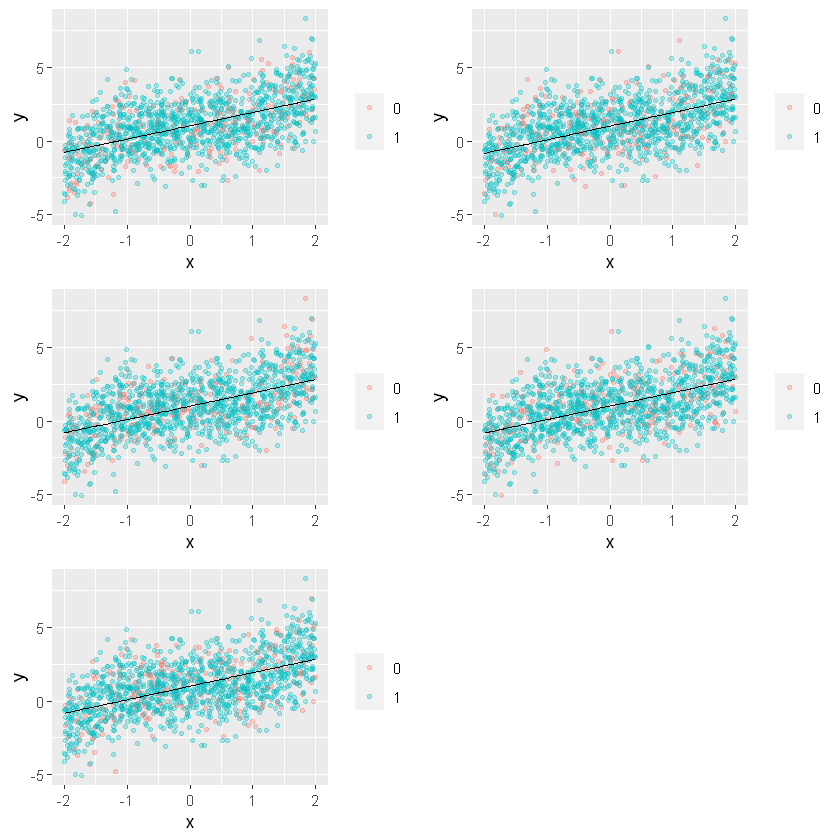

In [18]:
plts = list()
for (i in 1:num_folds){
    
    test_mask = as.logical(rep(sel[i,], size))
    visual = cbind(train_test, data.frame(train=!test_mask))
    
    pred = data.frame(ytest=yhat[,i], xtest=test[test_mask, "y"])

    plts[[i]] = ggplot(3, aes(x = x, y = y)) +
           geom_point(aes(color = factor(train)), alpha=.3, size=1) +
           geom_line(data=pred, aes(x=xtest, y=ytest)) + 
           theme(legend.title=element_blank())
}

grid.arrange(grobs=plts,ncol=2)

### Fitting all 8 Models

Now that we've seen how this works for one model choice, let's go ahead and estimate the remaining models. Again for illustration we wrote out a function that will do cross-validation in the linear model.


In [8]:
# Wrapping our previous code into a function
fit_models = function(train_test,n_folds, max_p){
    mse = array(,c(max_p,n_folds))
    for (p in 1:max_p){
        mse[p,] = CV_linear(train_test, n_folds, p)[1]
    }
    return(mse)
}

mse = fit_models(train_test,num_folds, max_p)

**Cross-Validation Results -- All 8 Models**

Now that we have performed 5-fold cross validation on all $8$ of our models! Let's see which one performed best (in terms of average "out-of-sample" MSE)

In [10]:
CV_mse = data.frame(mse,row.names=paste0("model", 1:max_p))
colnames(CV_mse) = seq(1,num_folds)
CV_mse

cat('5-fold CV picks: Model', which.min(rowMeans(CV_mse))[1])

## Display a table for MSE and print the minimum

,1,2,3,4,5
model1,2.4799013,2.6444139,2.340579,2.4672455,2.5853321
model2,1.8176123,1.7026965,1.460791,1.7009678,1.9134005
model3,1.2743410,1.2915052,1.966354,1.1822887,1.3996514
model4,0.7710116,0.8442342,1.023111,0.7910482,0.8094308
model5,0.7674733,0.8405352,2.858941,0.7927283,0.8057537
model6,0.4640511,0.4407953,3.591542,0.4074398,0.4532309
model7,0.4752736,0.3973252,4.015236,0.4089919,0.4004693
model8,0.2943553,0.2825031,29.520720,0.2509071,0.2987708


5-fold CV picks: Model 4

**Does Cross-Validation Work?**

Well that's pretty cool. Cross validation picked the right model! Although we knew what the correct model was, we didn't use that information anywhere in the estimation. The key thing was ensuring that the correct model was available for cross-validation to select. 

Will this always happen? Unfortunately, cross-validation isn't perfect, but as long as the proceedure is done properly, we will choose the right model most of the time!

**Validation Performance**

Now that we've chosen the model we can go ahead and estimate our model with the validation data and see how we do.

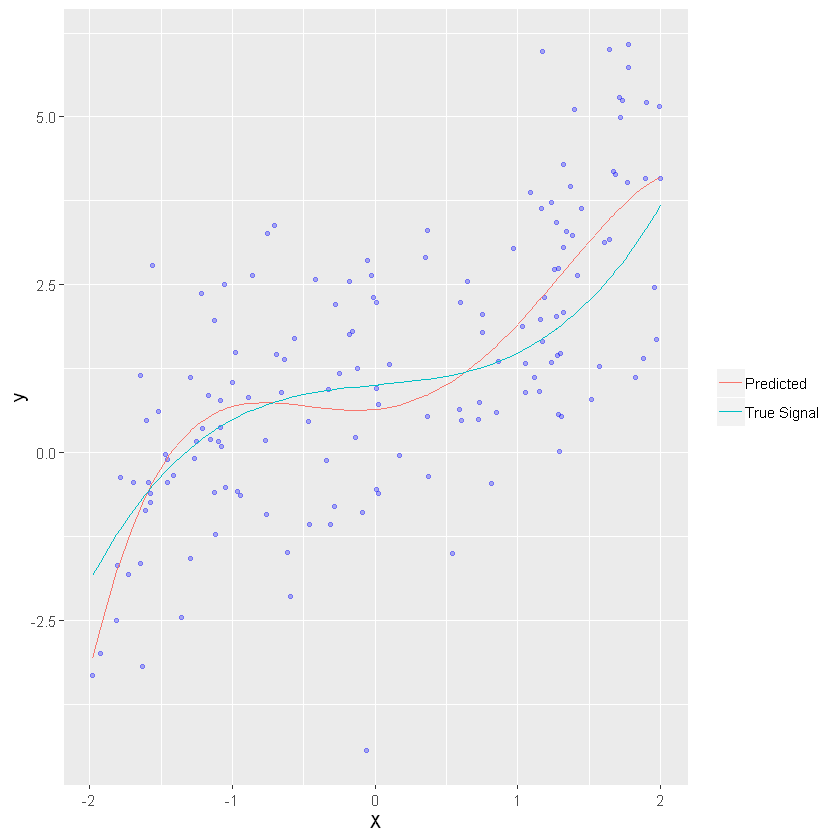

In [11]:
OLS = fit_poly(train_test, 4)
validation['y_hat'] = predict(OLS, newdata=validation)
validation['ybar'] = degree4_ybar(validation['x'])

ggplot(validation, aes(x=X, y=y)) +
           geom_point(color='blue', alpha=.3, size=1) +
           geom_line(data=pred, aes(x=X, y=y_hat, color="Predicted")) +
           geom_line(data=true, aes(x=X, y=ybar, color='True Signal')) +
           theme(legend.title=element_blank())

# Plot the validation data with the prediction and the truth together

# Exercise: Module 1

Using the functions defined in the module how would you re-run the analysis using 10 folds?

Does the proceedure still pick the right model?


In [12]:
num_folds_ex = 10
mse = fit_models(train_test,num_folds_ex)


CV_mse = data.frame(mse,row.names=model.names)
colnames(CV_mse) = seq(1,num_folds_ex)
CV_mse

cat('10-fold CV picks: Model', which.min(rowMeans(CV_mse))[1])

,1,2,3,4,5,6,7,8,9,10
model1,2.1595162,2.8208041,2.267656,2.7061820,2.4468547,2.8006035,2.4852569,2.4130347,2.2321535,2.7242217
model2,1.2547851,1.5962353,1.320887,2.1028622,1.7965957,2.4007222,1.8147466,1.5908666,1.3055844,2.0305176
model3,1.0270087,1.3827768,2.409548,1.2499353,1.2082340,1.5004590,1.2072399,1.2491736,1.1037278,1.5895715
model4,0.6361482,0.7678491,1.330632,0.9809029,0.7687012,0.8855462,0.9581610,0.6767009,0.6305173,0.8499244
model5,0.6452019,0.7674280,4.000035,0.9937717,0.7596019,0.8753063,0.9524136,0.6813816,0.6351884,0.8488395
model6,0.3989164,0.4864401,5.978880,0.4504427,0.4080723,0.5257562,0.4030578,0.4416376,0.3690863,0.4938190
model7,0.3579048,0.4067289,6.502434,0.5176139,0.3623554,0.5908642,0.4011529,0.3852204,0.3267555,0.4282110
model8,0.2902544,0.2976610,57.787667,0.2573139,0.2638084,0.2943745,0.2749451,0.3154191,0.2407259,0.3403850


10-fold CV picks: Model 4